# (31) Weight Decay — 1

**Motivation**: How does wd affect the results? Trying ```wd=0.0```. Device = ```cuda:1``` <br>

**Conclusion**: No weight decay is best (see other notebook). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from torch.nn import functional as F
from vae.vae import PoissonVAE, ConfigPoisVAE
from vae.train_vae import TrainerVAE, ConfigTrainVAE

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

## Build model + trainer

In [3]:
kws_vae = dict()
kws_tr = dict()

vae = PoissonVAE(ConfigPoisVAE(**kws_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**kws_tr), device=device)

In [31]:
tr.cfg.optimizer_kws

{'weight_decay': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08}

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3)_DOVES_z-512_k-32_lin+lin
ep3600-b1000-lr(0.005)_beta(1:0x0.3)_temp(0.05:exp-1.0)_gr(500)

In [6]:
vae.log_rates.detach().exp().min(), vae.log_rates.detach().exp().max()

(tensor(0.0025, device='cuda:1'), tensor(0.0494, device='cuda:1'))

In [7]:
vae.fc_dec.bias, vae.fc_enc.bias #.shape

(None, None)

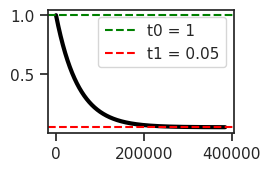

In [8]:
fig, ax = create_figure(1, 1, (2.4, 1.6))
ax.plot(tr.temperatures, color='k', lw=3)
ax.axhline(tr.cfg.temp_start, color='g', ls='--', label=f"t0 = {tr.cfg.temp_start:0.2g}")
ax.axhline(tr.cfg.temp_stop, color='r', ls='--', label=f"t1 = {tr.cfg.temp_stop:0.2g}")
ax.legend()
plt.show()

## Train

In [9]:
comment = f"wd-0_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 3600, avg loss: 166.921992: 100%|███████████████████████| 3600/3600 [29:33<00:00,  2.03it/s]


## Eval

### Loss vld (freeze)

In [11]:
data, loss, rates = tr.validate(temp=0.0)

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 137.09482, 'kl': 29.600822, 'kl_diag': 0.05714032, 'tot': 166.69565}

### Identify dead neurons

In [12]:
dead_thres = 0.003
dead = loss['kl_diag'] < dead_thres
dead.sum()

3

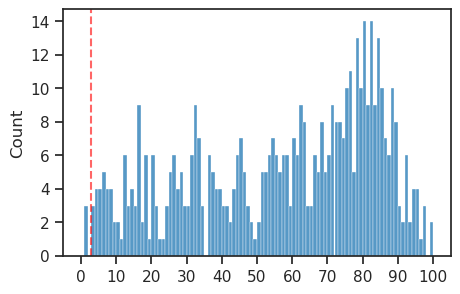

In [13]:
ax = sns.histplot(loss['kl_diag'] * 1000, bins=np.linspace(0, 100, 101))
ax.locator_params(axis='x', nbins=15)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
plt.show()

### Spike counts

In [14]:
tot = np.prod(data['z'].shape)
portions = data['z'][:, ~dead].ravel().astype(int)
portions = collections.Counter(portions)
portions = {
    k: v / tot for k, v in
    portions.most_common()
}
portions = {
    k: np.round(v * 100, 1) for
    k, v in portions.items()
    if v > 0.005
}

In [15]:
portions

{0: 73.5, 1: 20.0, 2: 4.6, 3: 1.0}

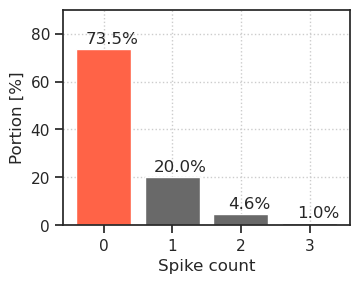

In [16]:
fig, ax = create_figure(1, 1, (3.7, 2.8))

ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(portions[0] / 10) + 1) * 10),
)

colors = ['tomato' if lbl == 0 else 'dimgrey' for lbl in portions]
bars = ax.bar(portions.keys(), portions.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='x', nbins=len(portions) + 1)
ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

### Cosine sim enc/dec

In [17]:
with torch.inference_mode():
    w_dec = tr.model.fc_dec.weight.detach().data
    w_enc = tr.model.fc_enc.weight.detach().data

    w_dec = w_dec[:, ~dead]
    w_enc = w_enc[~dead]

    cos_sim = F.cosine_similarity(w_dec.T, w_enc)
    slope = torch.einsum('ic, ci -> c', w_dec, w_enc)
    slope /= torch.norm(w_enc, dim=1).pow(2)

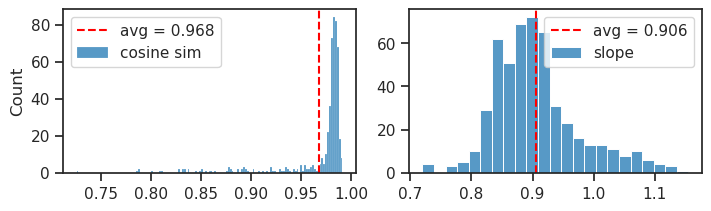

In [18]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(to_np(cos_sim), label='cosine sim', ax=axes[0])
sns.histplot(to_np(slope), label='slope', ax=axes[1])

_avg = cos_sim.mean().item()
axes[0].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')
_avg = slope.mean().item()
axes[1].axvline(_avg, color='r', ls='--', label=f'avg = {_avg:0.3g}')

for ax in axes.flat:
    ax.legend()
axes[1].set_ylabel('')
plt.show()

### Plot enc/dec weights

In [19]:
w_dec = tr.model.fc_dec.weight.T.reshape(tr.model.shape)
w_enc = tr.model.fc_enc.weight.reshape(tr.model.shape)

w_dec, w_enc = map(to_np, [w_dec, w_enc])
w_dec[dead] = np.nan
w_enc[dead] = np.nan

r8s = rates['r*dr'].mean(0)
w_dec = w_dec[np.argsort(r8s)]
w_enc = w_enc[np.argsort(r8s)]

grid_dec = make_grid(w_dec, (16, 32))
grid_enc = make_grid(w_enc, (16, 32))

w_dec.shape, grid_dec.shape

((512, 1, 16, 16), (271, 543))

In [20]:
kws = dict(
    vmin=0,
    vmax=1,
    cmap='Greys_r',
)

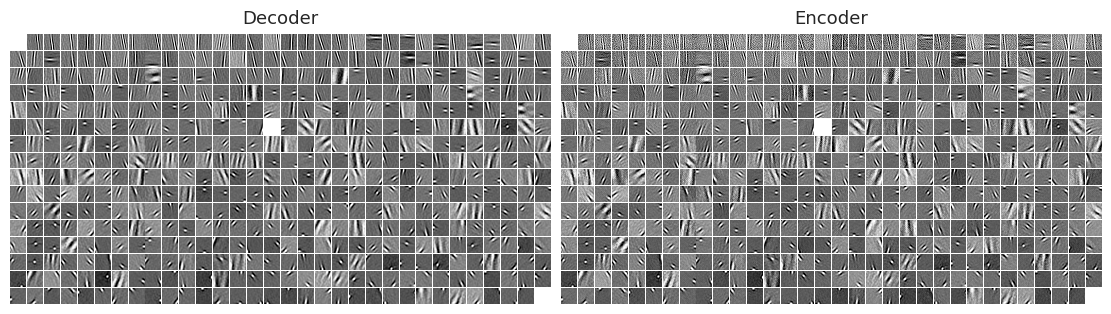

In [21]:
fig, axes = create_figure(1, 2, (11, 3.3), 'all', 'all', layout='constrained')

axes[0].imshow(grid_dec, **kws)
axes[1].imshow(grid_enc, **kws)
axes[0].set_title('Decoder', fontsize=13, y=1.01)
axes[1].set_title('Encoder', fontsize=13, y=1.01)
remove_ticks(axes)
plt.show()

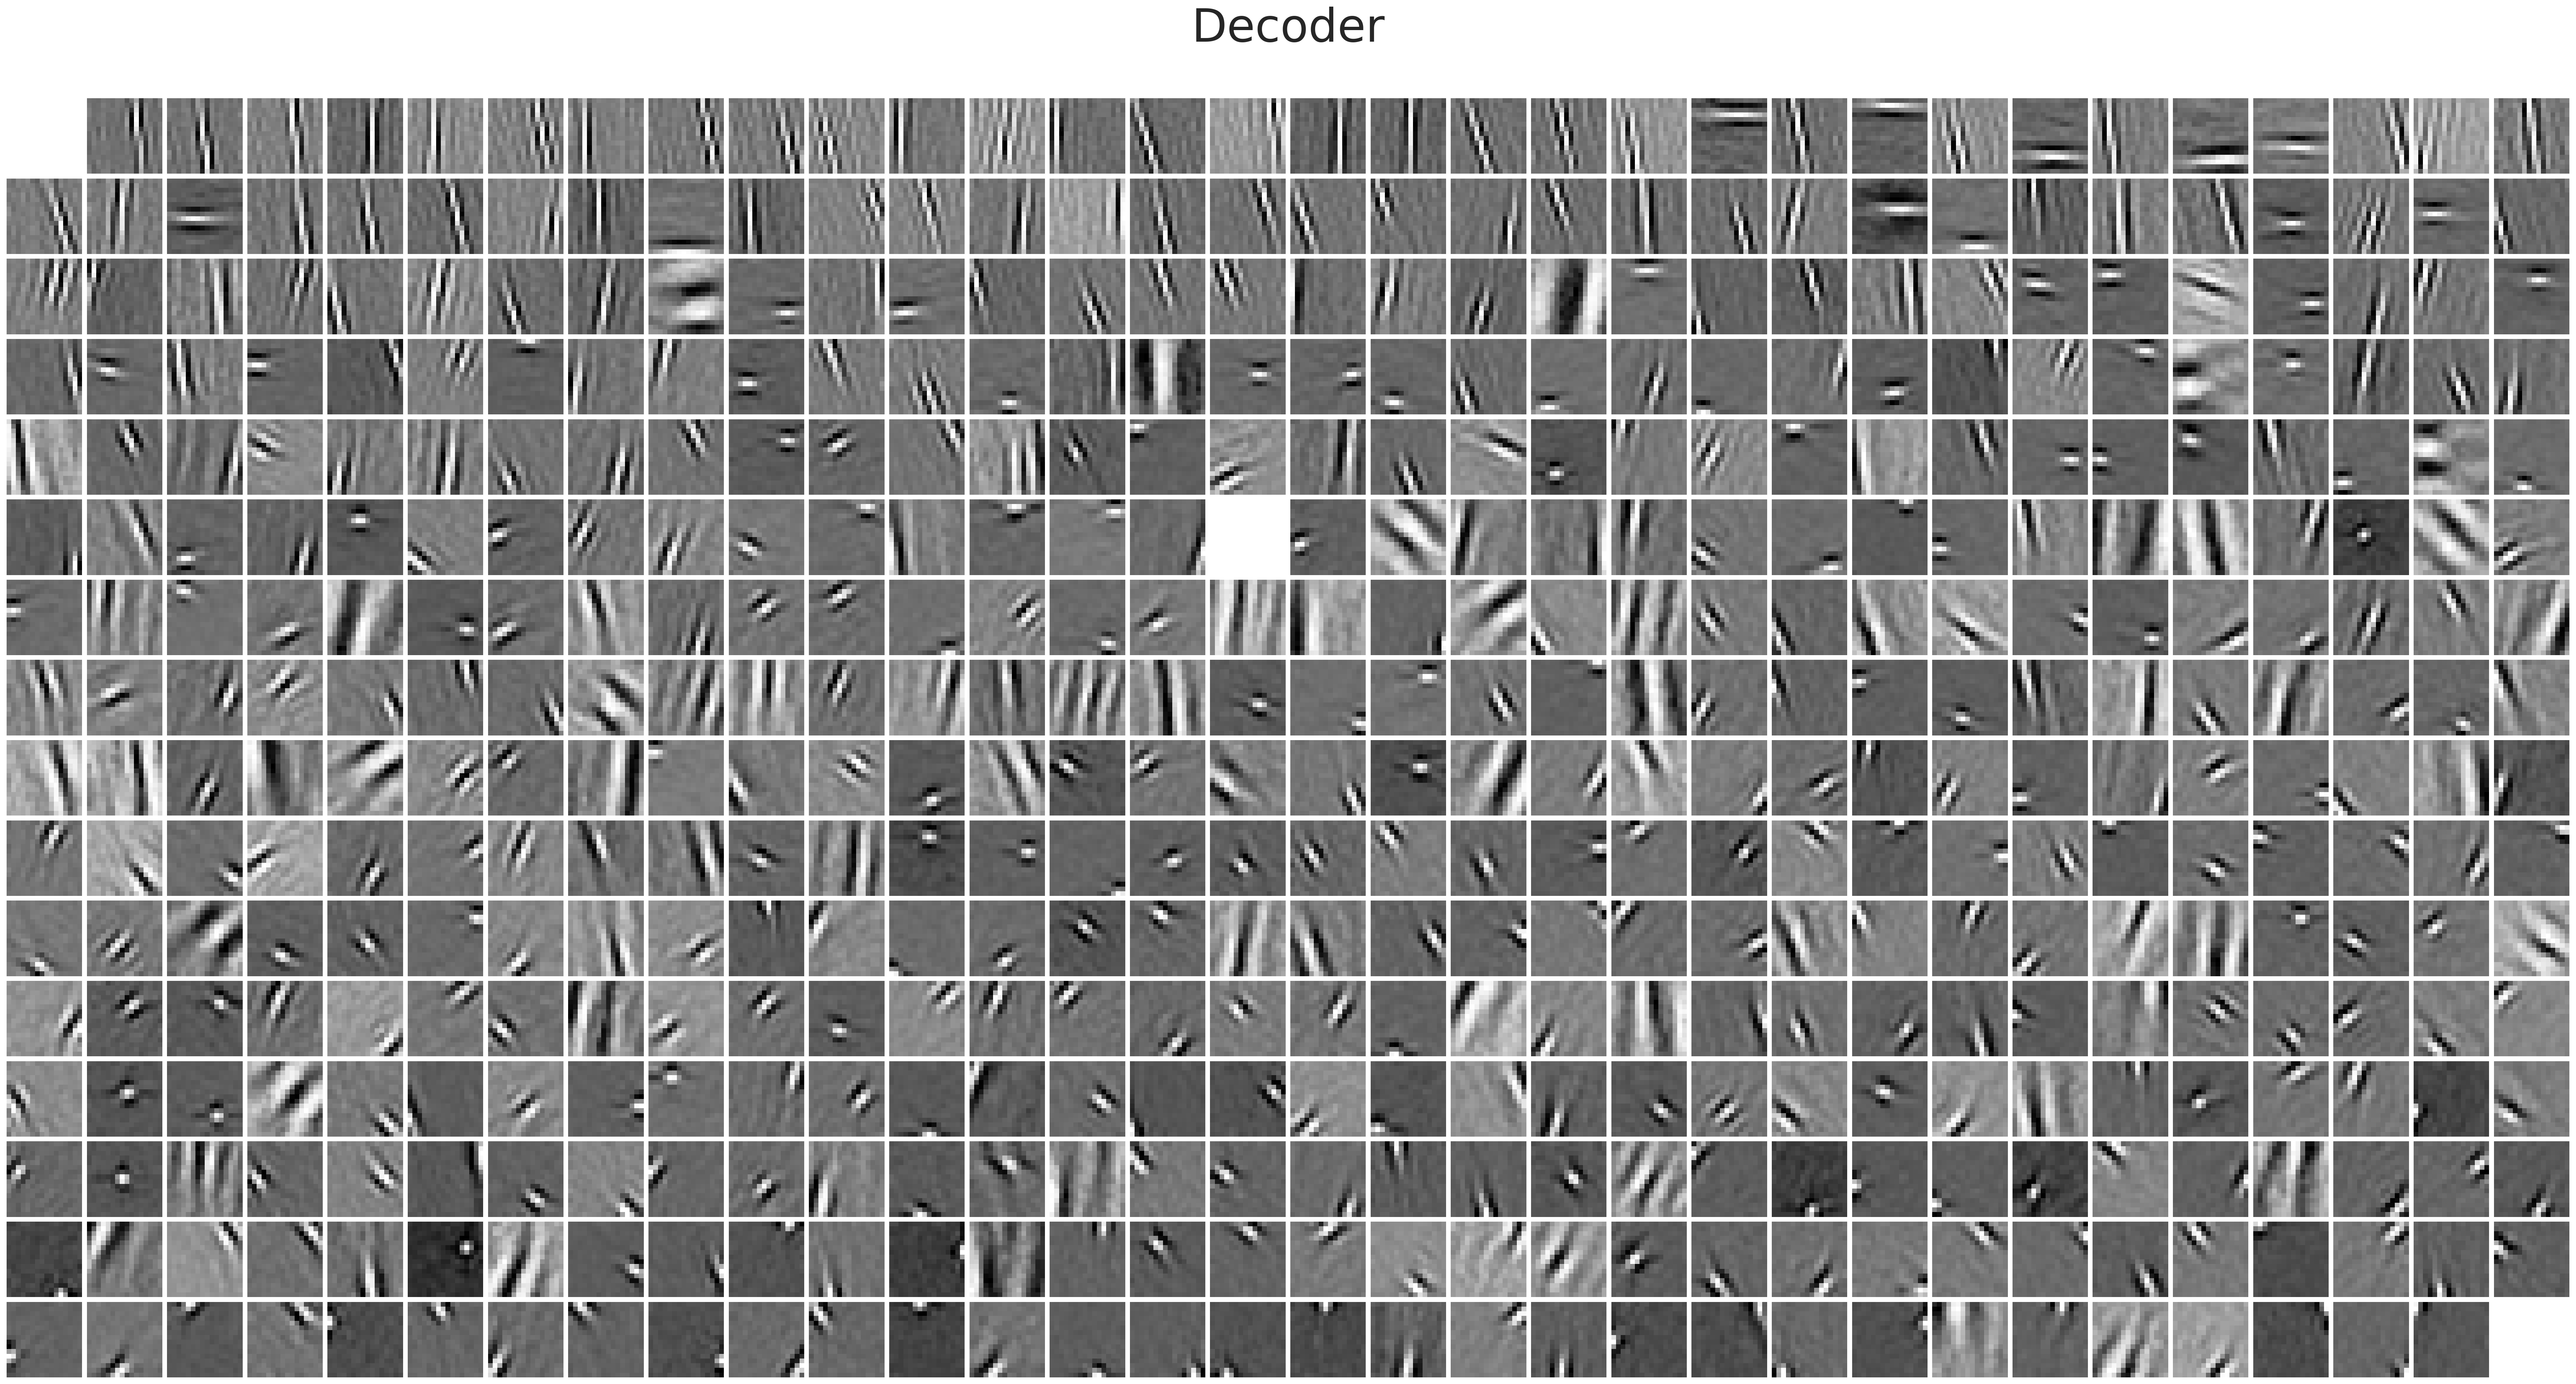

In [22]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, **kws)
ax.set_title('Decoder', fontsize=50, y=1.04)
remove_ticks(ax)
plt.show()

### make cmap

In [23]:
grid_dec = make_grid(w_dec, (16, 32), method='abs-max')
grid_enc = make_grid(w_enc, (16, 32), method='abs-max')

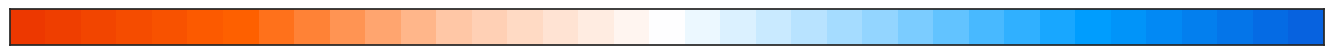

In [24]:
cmap = make_cmap(
    ['#ed3800', '#ff6100', '#ffc8a7',
     '#FFFFFF',
     '#94d6ff', '#009EFF', '#0762df'],
    name='RdOrBu',
    n_colors=512,
)

In [25]:
kws = dict(
    vmin=-1,
    vmax=1,
    cmap=cmap, # 'RdBu',
)

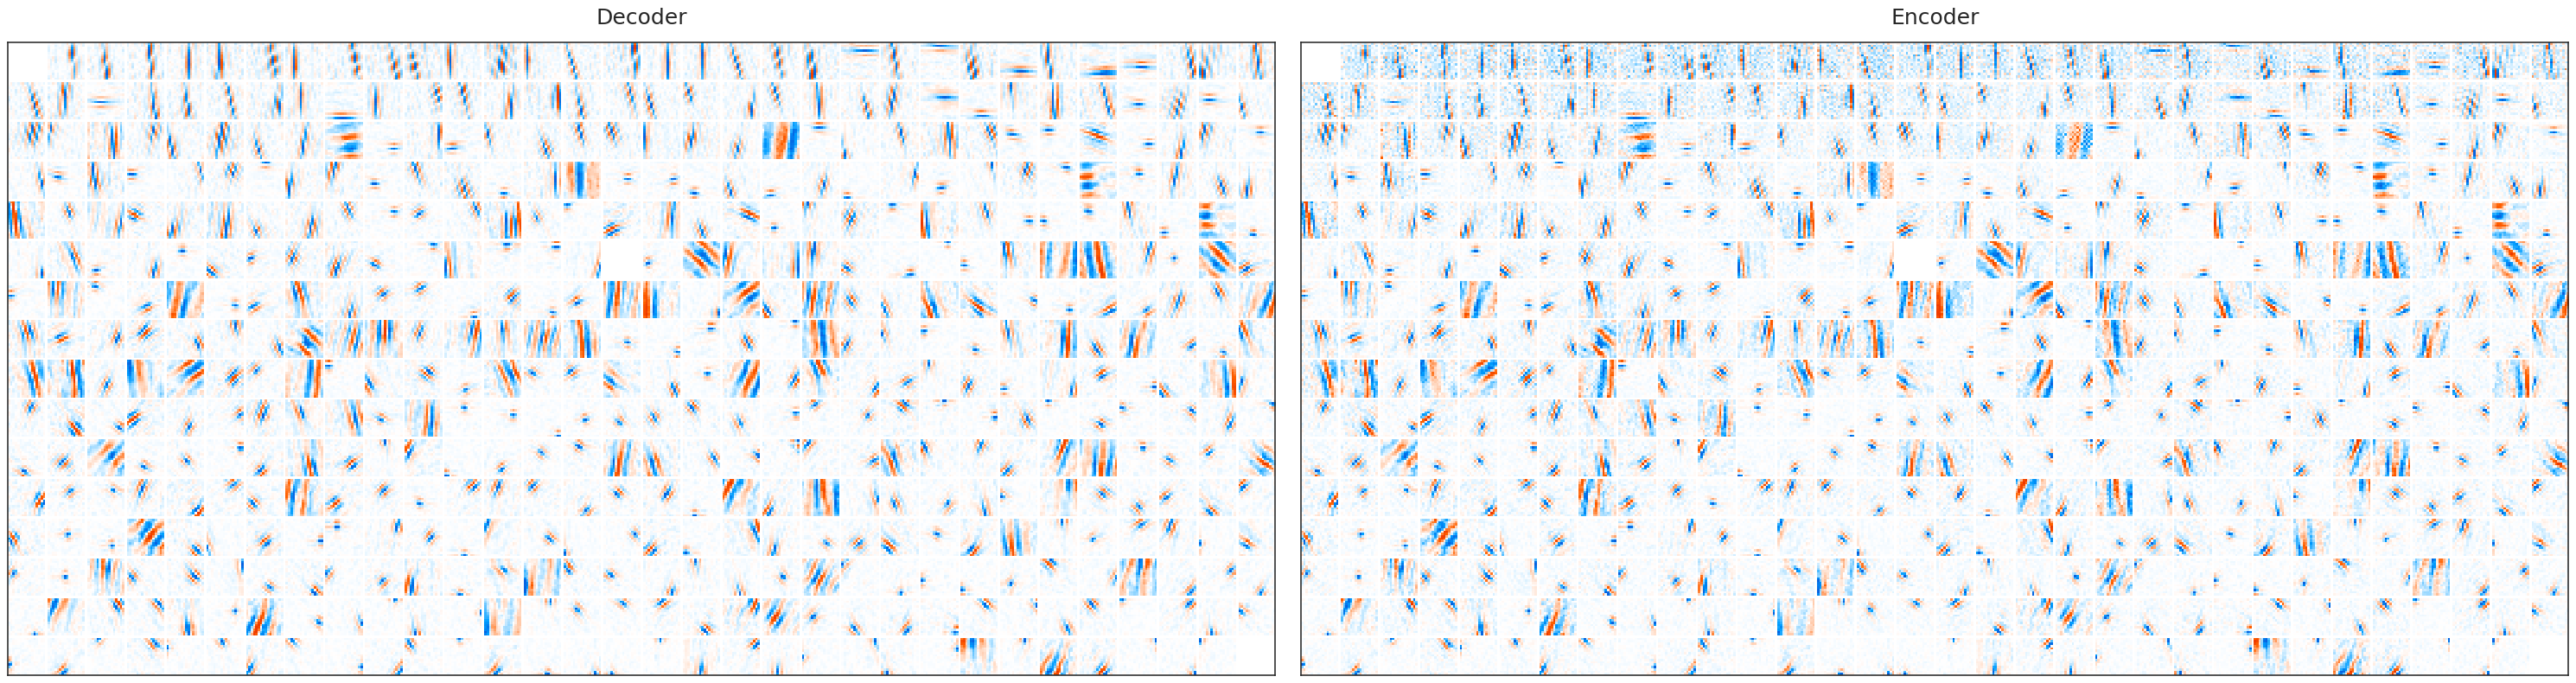

In [26]:
fig, axes = create_figure(1, 2, (33, 10), 'all', 'all', layout='constrained', dpi=90)

axes[0].imshow(grid_dec, **kws)
axes[1].imshow(grid_enc, **kws)
axes[0].set_title('Decoder', fontsize=20, y=1.02)
axes[1].set_title('Encoder', fontsize=20, y=1.02)
remove_ticks(axes, False)
plt.show()

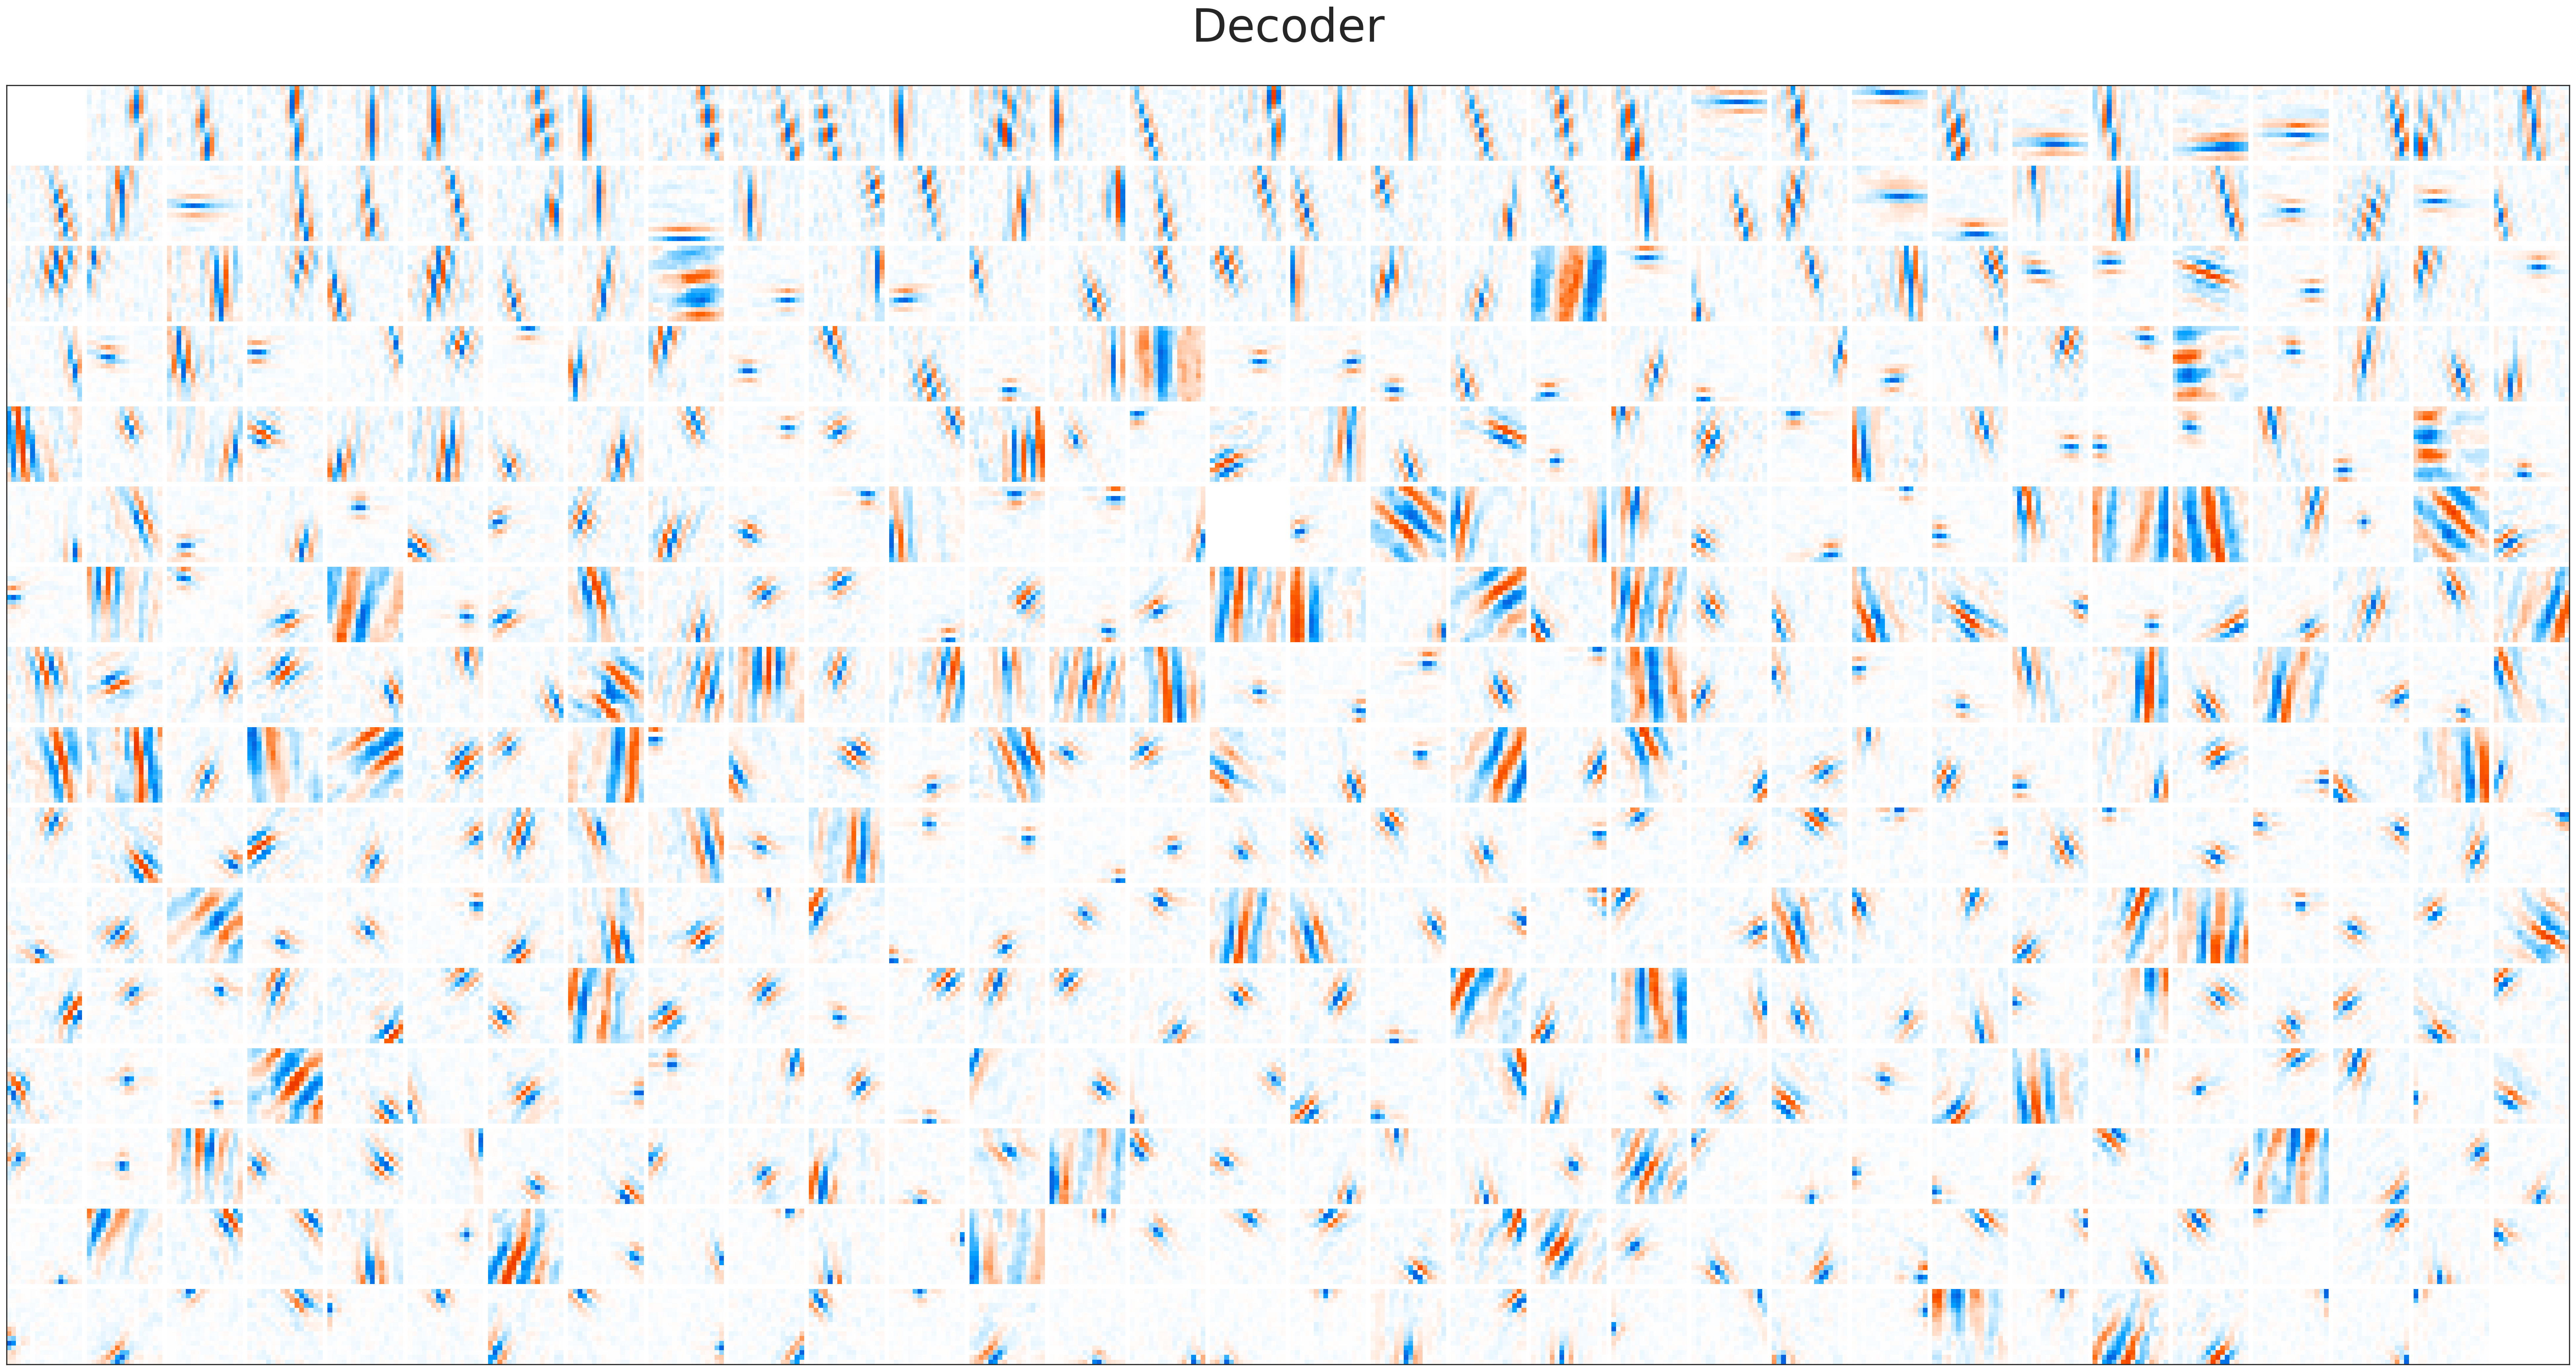

In [27]:
fig, ax = create_figure(1, 1, (50, 26), dpi=200)
ax.imshow(grid_dec, **kws)
ax.set_title('Decoder', fontsize=50, y=1.03)
remove_ticks(ax, False)
plt.show()

### Some more distributions

In [28]:
tr.model.temp, tr.cfg.kl_beta

(0.050475000000000006, 1.0)

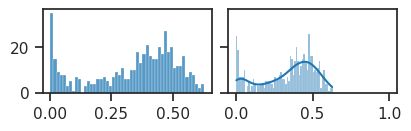

In [29]:
r8s = rates['r*dr'].mean(0)

fig, axes = create_figure(1, 2, (4, 1.2), sharey='all', layout='constrained')
sns.histplot(r8s[~dead], bins=50, ax=axes[0])
sns.histplot(r8s[~dead], bins=np.linspace(0, 1, 101), kde=True, ax=axes[1])
for ax in axes.flat:
    ax.set_ylabel('')
plt.show()

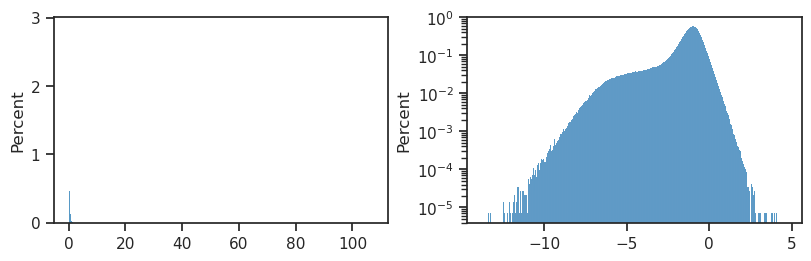

In [30]:
x2p = rates['r*dr'][:, ~dead].ravel()

fig, axes = create_figure(1, 2, (8, 2.5), layout='constrained')
sns.histplot(x2p, stat='percent', ax=axes[0])
sns.histplot(np.log(x2p), stat='percent', ax=axes[1])
axes[1].set_yscale('log')

In [32]:
data['z'].shape

(28224, 512)

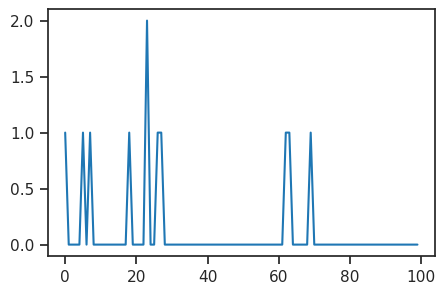

In [35]:
plt.plot(data['z'][:100, 2])

In [ ]:
## TODO: population / lifelong sparsity